# Generating LHC data with GANs

Here, we learn using Generative Adverserial Networks (GANs) to generate LHC data.

Background:
- Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful
- As a proof of concept, we will show how a GAN can be optimized to generate events simulated by traditional high energy physics simulation software
- The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$
- Naively, the dimension of this phase space is 8D, the 4 momentum of the two final state particles
- A GAN consists of a generative network and an adverserial network, trained through a min-max optimisation procedure
- The generative network samples random noise from a unit Normal distribution, passes it through a dense fully connected network to produce an 8D output
- The adverserial network then tries to classify between the generated data and the real data, and the generator is trained such that this adverserial network cannot classify between the generated data and the truth data anymore.

Interesting papers:
- Generative Adverserial Networks
    - Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
    - https://arxiv.org/abs/1406.2661
- How to GAN LHC events
    - Anja Butter, Tilman Plehn, Ramon Winterhalder
    - https://arxiv.org/abs/1907.03764
- How to GAN : Novel simulation methods for the LHC
    - Ramon Winterhalder
    - PhD thesis: https://inspirehep.net/literature/1839755

Outline:
- Imports and plotting set-up
- Study the data
- Datasets and dataloaders
- Building the GAN
- Optimising the GAN
- Study the results - let's generate some events!
- Removing redundant degrees of freedom
- Optimising the GAN on the reduced data
- Study the new results
- Concluding remarks

Some tips:
- GANs can require some thought in optimising them
- They need regularisation
- This is due to the min-max nature of the loss function
    - improving the generative network leads to a worsening of the classifier
- Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn.utils import spectral_norm

### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

# global plotting settings
FONTSIZE = 18

# matplotlib settings
plt.show()
plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}")
plt.rc("text", usetex=True)

# colors
colors = [f"C{i}" for i in range(5)]

In [ ]:
# global plotting settings
FONTSIZE = 18

# matplotlib settings
plt.show()
plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}")
plt.rc("text", usetex=True)

# colors
colors = [f"C{i}" for i in range(5)]

## Loading the data

We can load the data from here:

In [3]:
dy_trn_data = np.load( 'datasets/tutorial-2-data/dy_trn_data.npy' )
dy_val_data = np.load( 'datasets/tutorial-2-data/dy_val_data.npy' )
dy_tst_data = np.load( 'datasets/tutorial-2-data/dy_tst_data.npy' )

In [4]:
dy_trn_data.shape, dy_val_data.shape, dy_tst_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

## Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [340]:
def get_obs( event ):
    
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    evnt_4m = np.sum( (jet1_4m,jet2_4m), axis=0 )
    
    evnt_im = np.sqrt( np.sum( ( evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0 ) )
    
    evnt_pt = np.sqrt( evnt_4m[:,1]**2 + evnt_4m[:,2]**2 )
    jet1_pt = np.sqrt( jet1_4m[:,1]**2 + jet1_4m[:,2]**2 )
    jet2_pt = np.sqrt( jet2_4m[:,1]**2 + jet2_4m[:,2]**2 )
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

Now test it:

In [6]:
get_obs( dy_trn_data[0:2] )

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum.

Let's get the observables for the whole dataset:

In [7]:
trn_evnt_ims, trn_evnt_pts, trn_jet1_pts, trn_jet2_pts = get_obs( dy_trn_data )
val_evnt_ims, val_evnt_pts, val_jet1_pts, val_jet2_pts = get_obs( dy_val_data )
tst_evnt_ims, tst_evnt_pts, tst_jet1_pts, tst_jet2_pts = get_obs( dy_tst_data )

In [328]:
trn_evnt_ims.shape

(1384081,)

Let's plot the invariant mass of the events:

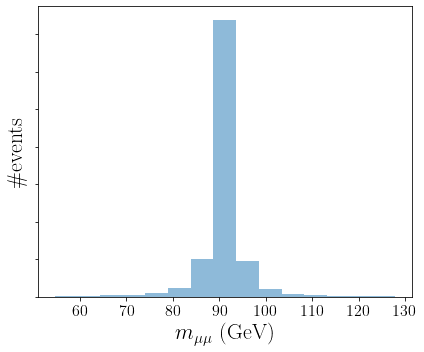

In [9]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_evnt_ims, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$m_{\mu\mu}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

fig.tight_layout()
fig.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

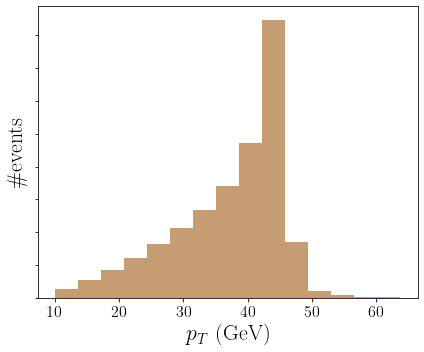

In [10]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_jet1_pts, alpha=0.5, density=True, bins=15 )
axs.hist( trn_jet2_pts, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$p_\text{T}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels(yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

fig.tight_layout()
fig.show()

These distributions are completely overlapping with a peak near $m_{\mu\mu}/2$.

## Datasets and dataloaders

This time we only need the dataloader to return the data, no labels, so it's pretty simple.

In [11]:
class drell_yan_data( Dataset ):
    
    def __init__( self, data ):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

Let's normalise the data a little bit by dividing all dimensionful quantities by $100$ GeV.

In [12]:
dy_trn_data_p = torch.Tensor( dy_trn_data / 100 )
dy_val_data_p = torch.Tensor( dy_val_data / 100 )
dy_tst_data_p = torch.Tensor( dy_tst_data / 100 )

In [13]:
trn_dataset = drell_yan_data( dy_trn_data_p )
val_dataset = drell_yan_data( dy_val_data_p )
tst_dataset = drell_yan_data( dy_tst_data_p )

Using a bigger batch size this time, this helps for generative networks.

In [14]:
trn_dataloader = DataLoader( trn_dataset, batch_size=2500, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=2500, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=2500, shuffle=True )

## Building the GAN

We need two networks, a generative network and an adverserial network:

In [118]:
class drellGAN_gen( torch.nn.Module ):
    
    def __init__( self, data_dim, latent_dim, hiddenlayer_size ):
        super( drellGAN_gen, self ).__init__()
        
        self.latent_dim = latent_dim
        
        self.layer1 = nn.Linear( latent_dim, hiddenlayer_size )
        self.relu_1 = nn.LeakyReLU(0.1)
        self.layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.relu_2 = nn.LeakyReLU(0.1)
        self.layer3 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.relu_3 = nn.LeakyReLU(0.1)
        self.layer4 = nn.Linear( hiddenlayer_size, data_dim )
        
    def forward( self, batch ):
        
        x = self.layer1( batch )
        x = self.relu_1( x )
        x = self.layer2( x )
        x = self.relu_2( x )
        x = self.layer3( x )
        x = self.relu_3( x )
        x = self.layer4( x )
        
        return x

In [130]:
class drellGAN_dis( torch.nn.Module ):
    
    def __init__( self, data_dim, hiddenlayer_size ):
        super( drellGAN_dis, self ).__init__()
                
        self.layer1 = spectral_norm( nn.Linear( data_dim, hiddenlayer_size ), n_power_iterations=2 ) 
        self.relu_1 = nn.LeakyReLU(0.1)
        self.layer2 = spectral_norm( nn.Linear( hiddenlayer_size, hiddenlayer_size ), n_power_iterations=2 )
        self.relu_2 = nn.LeakyReLU(0.1)
        self.layer3 = spectral_norm( nn.Linear( hiddenlayer_size, hiddenlayer_size ), n_power_iterations=2 )
        self.relu_3 = nn.LeakyReLU(0.1)
        self.layer4 = spectral_norm( nn.Linear( hiddenlayer_size, 1 ), n_power_iterations=2 )
        
    def forward( self, batch ):
        
        x = self.layer1( batch )
        x = self.relu_1( x )
        x = self.layer2( x )
        x = self.relu_2( x )
        x = self.layer3( x )
        x = self.relu_3( x )
        x = self.layer4( x )
        
        return x

A few points here:
- We're using LeakyReLU rather than ReLU, this has been shown to work well in our tests
    - check it out: https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html
- We use spectral norm on every layer in the discriminator
    - The discriminator needs to be regulated, otherwise it dominates in the optimisation
    - spectral norm does this
    - check it out here: https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html
- The latent space dimension in the generative network does not need to be the same as the data dimension

## Optimizing the GAN

First, we set the device.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


We need two loss functions, one for the generative part and one for the adverserial.

The adverserial net is just a classifier, so it's loss is simple, binary cross entropy.

For the generative network we can also use the binary cross entropy, where the labels for the generated and true data are:
- 0 for generated data
- 1 for true data

For the loss function we use the BCEWithLogitsLoss loss function.

This passes the input through a sigmoid before putting it into the BCE loss.  The logarithms from the BCE and the exponentials in the sigmoids are then treated in more numerically stable way.

To get the correct loss function for updates of the generative network, we are required to compute the loss using fake data and the real labels.

Lastly, we of course now need to pass the models, optimisers, and schedulers for both networks to the train_epoch function.

Check it out here:  https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

In [18]:
loss_fn = nn.BCEWithLogitsLoss()

In [332]:
def train_epoch( dataloader, gen_model, dis_model, loss_fn, gen_optimizer, dis_optimizer, gen_scheduler, dis_scheduler ):
    
    size = len( dataloader.dataset )
    
    for batch, x_real in enumerate(dataloader):
        
        # calculate the batch_len and the num_obs in the input
        # we can't just use the batch_size we defined, the last batch in the epoch is unlikely to be complete
        batch_len = x_real.shape[0]
        num_obs = x_real.shape[1]
        
        # reset gradients in optimizers
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        # define labels
        lbls_real = torch.ones( batch_len ).unsqueeze(-1)
        lbls_fake = torch.zeros( batch_len ).unsqueeze(-1)
        
        '''
        DISCRIMINATOR UPDATE
        '''
        
        # sample random noise for the generative network
        z_gen = torch.randn( batch_len, gen_model.latent_dim, device=device )

        # pass data through generative network
        x_gen = gen_model( z_gen )
        
        # pass data through discriminative network
        # detach x_gen because we do not want to compute generative model gradients
        out_real = dis_model( x_real )
        out_fake = dis_model( x_gen.detach() )
        
        # compute loss
        dis_loss_real = loss_fn( out_real, lbls_real )
        dis_loss_fake = loss_fn( out_fake, lbls_fake )
        
        # compute gradients
        dis_loss_real.backward()
        dis_loss_fake.backward()
        dis_loss = dis_loss_real + dis_loss_fake
        
        # update discriminative network weights with optimizer
        dis_optimizer.step()
        
        '''
        GENERATOR UPDATE
        '''
        
        # pass the fake data through the discriminator again since we've now updated those weights
        gen_model.zero_grad()
        out_fake = dis_model( x_gen )
        
        # zero gradients then compute gradients
        # note the use of lbls_real
        gen_loss = loss_fn( out_fake, lbls_real )
        gen_loss.backward()
        
        # update generative network weights with optimizer
        gen_optimizer.step()
        
        '''
        PRINT STATS
        '''
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            dis_loss, gen_loss, current = dis_loss.item(), gen_loss.item(), batch * len(x_real)
            print( f"dis loss: {dis_loss:>7f}  [{current:>5d}/{size:>5d}]" )
            print( f"gen loss: {gen_loss:>7f}  [{current:>5d}/{size:>5d}]" )
            print( "--" )
    
    # update the schedulers
    gen_scheduler.step()
    dis_scheduler.step()

We want to evaluate how well the training is going for the training and validation data.
We do this by seeing how well the classifier can classify between the real and fake data.

In [76]:
def val_pass( dataloader, gen_model, dis_model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0
    
    lbls_real = torch.ones( 64 ).unsqueeze(-1)
    lbls_fake = torch.zeros( 64 ).unsqueeze(-1)
    lbls = torch.concat( (lbls_real, lbls_fake), dim=0 )

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x_real in dataloader:
            batch_len = x_real.shape[0]
            num_obs = x_real.shape[1]
            lbls_real = torch.ones( batch_len ).unsqueeze(-1)
            lbls_fake = torch.zeros( batch_len ).unsqueeze(-1)
            lbls = torch.concat( (lbls_real, lbls_fake), dim=0 )
            z_gen = torch.randn( batch_len, gen_model.latent_dim, device=device )
            x_gen = gen_model( z_gen )
            out_real = dis_model( x_real )
            out_fake = dis_model( x_gen )
            out = torch.concat( (out_real, out_fake), dim=0 )
            vl += loss_fn( out, lbls ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, gen_model, dis_model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x_real in dataloader:
            batch_len = x_real.shape[0]
            num_obs = x_real.shape[1]
            lbls_real = torch.ones( batch_len ).unsqueeze(-1)
            lbls_fake = torch.zeros( batch_len ).unsqueeze(-1)
            lbls = torch.concat( (lbls_real, lbls_fake), dim=0 )
            z_gen = torch.randn( batch_len, gen_model.latent_dim, device=device )
            x_gen = gen_model( z_gen )
            out_real = dis_model( x_real )
            out_fake = dis_model( x_gen )
            out = torch.concat( (out_real, out_fake), dim=0 )
            tl += loss_fn( out, lbls ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

To optimize the network we need separate optimizers for each model, and we also add a learning rate scheduler regulate the training further.

In [344]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 20

gen_model = drellGAN_gen( 8, 8, 64 ).to(device)
dis_model = drellGAN_dis( 8, 64 ).to(device)
learning_rate = 0.001
gen_optimizer = torch.optim.Adam( gen_model.parameters(), lr=learning_rate, betas = (0.5, 0.9), weight_decay = 0. )
dis_optimizer = torch.optim.Adam( dis_model.parameters(), lr=learning_rate, betas = (0.5, 0.9), weight_decay = 0. )
gen_scheduler = torch.optim.lr_scheduler.StepLR( optimizer=gen_optimizer, step_size=1, gamma = 0.999 )
dis_scheduler = torch.optim.lr_scheduler.StepLR( optimizer=dis_optimizer, step_size=1, gamma = 0.999 )
separator()
print( "model architecture ")
separator()
print( gen_model )
print( dis_model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, gen_model, dis_model, loss_fn, gen_optimizer, dis_optimizer, gen_scheduler, dis_scheduler )
    separator()
    trn_loss = trn_pass( trn_dataloader, gen_model, dis_model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, gen_model, dis_model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
drellGAN_gen(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.1)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): LeakyReLU(negative_slope=0.1)
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (relu_3): LeakyReLU(negative_slope=0.1)
  (layer4): Linear(in_features=64, out_features=8, bias=True)
)
drellGAN_dis(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.1)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): LeakyReLU(negative_slope=0.1)
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (relu_3): LeakyReLU(negative_slope=0.1)
  (layer4): Linear(in_features=64, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
--------------------------------------------

dis loss: 1.400078  [750000/1384081]
gen loss: 0.694193  [750000/1384081]
--
dis loss: 1.388859  [1000000/1384081]
gen loss: 0.692901  [1000000/1384081]
--
dis loss: 1.382900  [1250000/1384081]
gen loss: 0.696232  [1250000/1384081]
--
-----------------------------------------------
avg trn loss per batch: 0.695004
-----------------------------------------------
avg val loss per batch: 0.695027
-----------------------------------------------
|
-----------------------------------------------
Epoch 11
-----------------------------------------------
dis loss: 1.390325  [    0/1384081]
gen loss: 0.687431  [    0/1384081]
--
dis loss: 1.382441  [250000/1384081]
gen loss: 0.694915  [250000/1384081]
--
dis loss: 1.382580  [500000/1384081]
gen loss: 0.697097  [500000/1384081]
--
dis loss: 1.388398  [750000/1384081]
gen loss: 0.694015  [750000/1384081]
--
dis loss: 1.388981  [1000000/1384081]
gen loss: 0.696942  [1000000/1384081]
--
dis loss: 1.386909  [1250000/1384081]
gen loss: 0.698748  [1250

## Study the results

First let's plot the training and validation losses to see how they look.

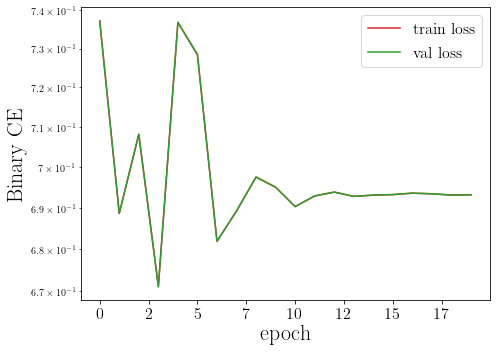

In [345]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.plot( trn_losses, label="train loss", color=colors[0] )
axs.plot( val_losses, label="val   loss", color=colors[1] )

axs.set_yscale('log')

axs.set_xlabel( "epoch")
axs.set_ylabel( "Binary CE")

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

yticks = axs.get_yticks()
axs.set_yticklabels( yticks)

axs.legend( loc='best')

fig.tight_layout()

## Let's generate some events!

We first need to generate random data from the unit normal distribution, the same used during training, with the correct shape.  Here we use $10$k samples.

In [346]:
z_gen = torch.randn( (10000, gen_model.latent_dim) )
x_gen = gen_model( z_gen )*100.0

In [347]:
x_gen.shape

torch.Size([10000, 8])

Plot the energy distribution of the first jet, for both real and generated data:

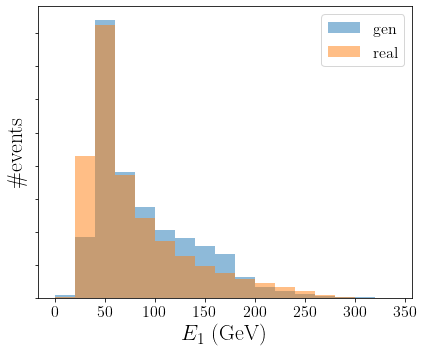

In [348]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 0, 350, step=20 )
axs.hist( x_gen.detach().numpy()[:,0], alpha=0.5, density=True, bins=bins, label='gen' , color=colors[0])
axs.hist( dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real' , color=colors[1])

axs.set_xlabel( "$E_{1}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

axs.legend( loc='best')

fig.tight_layout()
fig.show()

Looks good!!

We can do the same for $p_y$ of the first jet:

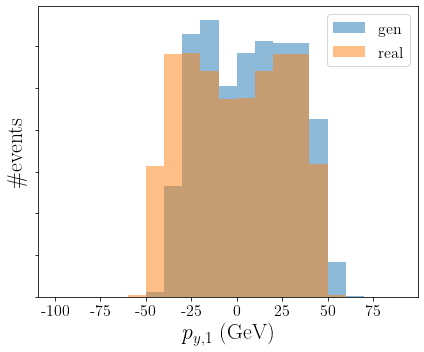

In [349]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -100, +100, step=10 )
axs.hist( x_gen.detach().numpy()[:,2], alpha=0.5, density=True, bins=bins, label='gen', color=colors[0] )
axs.hist( dy_trn_data[:,2], alpha=0.5, density=True, bins=bins, label='real', color=colors[1] )

axs.set_xlabel( "$p_{y,1}$ ;GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks )

axs.legend( loc='best')

fig.tight_layout()
fig.show()

Not bad!

Now we can look at more complicated observables which involve correlations between the different inputs.

first we need to calucate them from the generated data:

In [350]:
x_gen_evnt_ims, x_gen_evnt_pts, x_gen_jet1_pts, x_gen_jet2_pts = get_obs( x_gen.detach().numpy() )

The $p_T$ of the first jet:

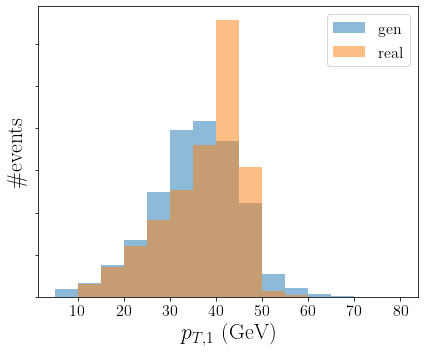

In [351]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 85, step=5 )
axs.hist( x_gen_jet1_pts, alpha=0.5, density=True, bins=bins, label='gen', color=colors[0] )
axs.hist( trn_jet1_pts, alpha=0.5, density=True, bins=bins, label='real', color=colors[1] )

axs.set_xlabel( "$p_{T,1}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

axs.legend( loc='best')

fig.tight_layout()
fig.show()

Looks good!

Now the invariant mass of the whole event:

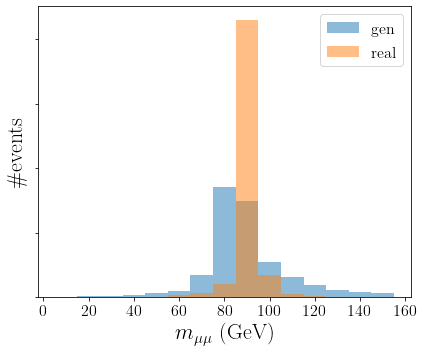

In [352]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 165, step=10 )
axs.hist( np.nan_to_num( x_gen_evnt_ims ), alpha=0.5, density=True, bins=bins, label='gen', color=colors[0] )
axs.hist( np.nan_to_num( trn_evnt_ims ), alpha=0.5, density=True, bins=bins, label='real', color=colors[1] )

axs.set_xlabel( "$m_{\mu\mu}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

axs.legend( loc='best')

fig.tight_layout()
fig.show()

This is slightly less good..

Why?

The $p_T$ is just a linear function of just two of the inputs, while the invariant mass non-linear function of all observables and so is less trivial correlation for the GAN to learn.

## Concluding remarks

What else can we try?
- Varying the latent space size
    - Can be useful for modelling complicated multi-modal distributions
- Larger networks
- Maximum Mean Discrepancy (MMD) to resolve sharp features like invariant masses
- Better regularisation
- Change data parametrization